Este conteúdo é uma reprodução comentada do tutorial do TensorFlow disponível em: https://www.tensorflow.org/tutorials/keras/regression#top_of_page

# Conteúdo

In [2]:
# Importando as bibliotecas base
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Tornando as matrizes numpy mais limpas
np.set_printoptions(precision=3, suppress=True)

In [3]:
# Importando o tensorflow e os pacotes e subpacotes do keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.1


# Os dados do Auto MPG dataset

Os dados estão disponívies em https://archive.ics.uci.edu/ml/index.php

## Adquirindo os dados

In [4]:
# Importando os dados Auto MPG dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Limpando os dados

In [6]:
# Análise da quantidade de dados faltantes
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# Retirada dos dados faltantes
dataset = dataset.dropna()

In [8]:
# Cada número da coluna 'Origin' é uma categoria, desta forma, essas categorias são mapeadas
dataset['Origin'] = dataset['Origin'].map({
                                            1: 'USA',
                                            2: 'Europe',
                                            3: 'Japan'
})

In [9]:
# A partir deste mapeamento são criadas novas colunas de cada categoria
# e a indicação de pertencimento é dada por 0 e 1, onde 1 é pertence
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Separação entre dados de treino e de teste

In [10]:
# Separação entre dados de treino e de teste
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspecionando os dados

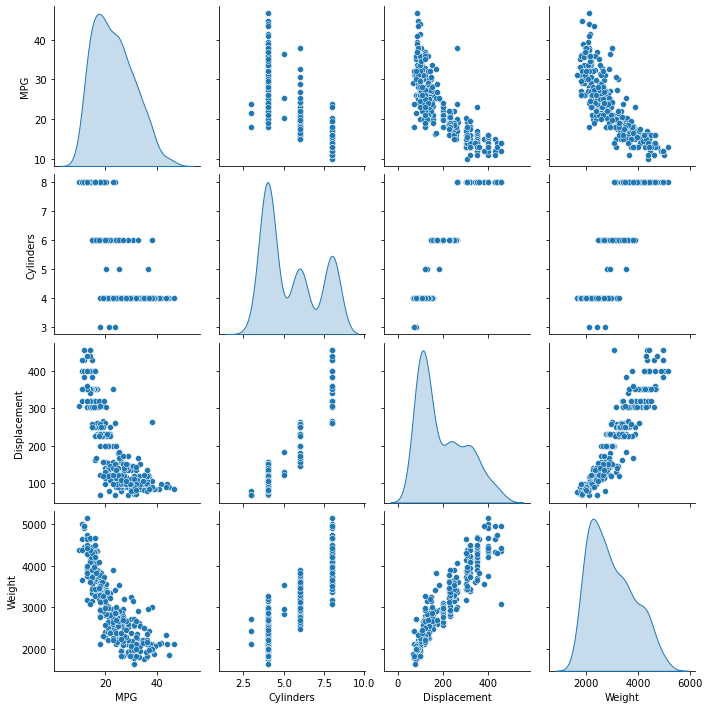

In [11]:
# Exploração dos dados por meio de gráficos em pares
# É possível perceber a distribuição dos dados nos gráficos da diagonal
# É possível perceber a relação entre os atributos, uma tendência ao olhar os gráficos
# isto indica que existem relações entre eles
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
# Gerando uma tabela que descreve estatisticamente os dados
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Separando os atributos dos rótulos

In [13]:
# Separação das 'rótulos', valores que desejam ser preditos dos atributos
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# .pop faz a retirada da coluna de rótulos dos dados
# desta forma em train_features permanece somente os atributos
# e em train_labels ficam as etiquetas
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Normalização

In [14]:
# Análise somente da média e desvio padrão dos dados
train_dataset.describe().transpose()[['mean', 'std']]

# As estatísticas permitem verificar que os dados tem intervalos distintos
# desta forma normalizar os dados é uma boa forma de melhorar a estabilidade
# do treinamento

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


## Camada de normalização

In [15]:
# Criando a camada de normalização
normalizer = preprocessing.Normalization()

In [16]:
# Adaptando a camada aos dados de treino
normalizer.adapt(np.array(train_features))

In [17]:
# Desta forma a camada calcula a média e a variância (responsáveis para normalização)
# e guarda na camada
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [18]:
# Analisando o que a camada faz
# ela pega os dados de entrada e gera como saída os valores normalizados
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Regressão linear

## Uma variável

In [48]:
# Primeiro será avaliado um modelo de regressão linear somente 
# com a variável 'horsepower'
# Criando a camamada de normalização do 'horsepower'
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1, ])
horsepower_normalizer.adapt(horsepower)

In [49]:
# Agora será criada a rede neural com 2 camadas
# A primeira camada é a de normalização dos dados 'horsepower'
# A segunda cmada é a de operação linear dos dados(y = mx+b)
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

# .summary() mostra em um sumário as camadas e quantidades de parâmetros
horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [50]:
# Neste passo somente é avaliado a saída se está no formato correto
# Observação: o modelo ainda não foi treinado
horsepower_model.predict(horsepower[:10])

array([[-0.354],
       [-0.2  ],
       [ 0.652],
       [-0.496],
       [-0.448],
       [-0.176],
       [-0.531],
       [-0.448],
       [-0.117],
       [-0.2  ]], dtype=float32)

In [51]:
# Agora é definido como será o treino com o .compile()
# O otimizador será o ADAM com a taxa de aprendizado de 0.1
# e a função perda será o erro absoluto médio (MAE)
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [52]:
%%time
# O comando %%time é chamado de magic line, em que é computado o tempo de operação
# Com as camadas e o treinamento definido será realizado o treinamento
# efetivamente, com o .fit()
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suprress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 4.26 s


In [53]:
# O objeto 'history' guarda as informações do histórico de treinamento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.807271,4.184035,95
96,3.805544,4.193879,96
97,3.804000,4.172601,97
98,3.804315,4.168127,98
99,3.805211,4.177405,99


In [54]:
# Será definido uma função para a criação do gráfico de
# erro por época tanto para o erro de treino quanto para o de validação
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

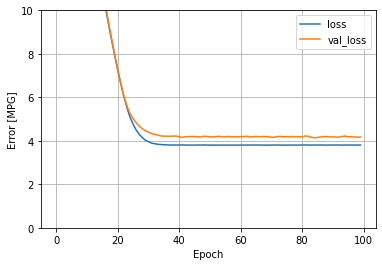

In [55]:
# Agora será utilizada a função para criar o gráfico do treinamento passado
plot_loss(history)

In [56]:
# É criado os resultados para o teste a serem avaliados depois
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [57]:
# Será visualizado em um gráfico o que está sendo predito e os dados de treino
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [58]:
# Para a construção do gráfico é criada uma função
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

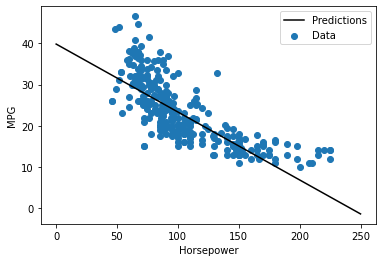

In [59]:
plot_horsepower(x, y)

## Múltiplas entradas

In [60]:
# Neste momento será utilizado todos os atributos disponíveis para serem
# treinados e prever os rótulos
# Será utilizada como camada de normalização o 'normalizer' criado anteriormente
# E terá como segunda camada o mesmo tipo de camada linear (y = mx+b)
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
]) 

In [62]:
# Como anteriormente também será avaliada se a saída do modelo está conforme
# como colocamos no layers.Dense o units=1, a saída deverá ser um único valor, escalar
linear_model.predict(train_features[:10])

array([[ 0.523],
       [-0.123],
       [-0.025],
       [-0.871],
       [ 0.222],
       [ 0.349],
       [ 0.535],
       [-0.347],
       [ 0.804],
       [ 1.63 ]], dtype=float32)

In [64]:
# Para saber quais sãos os pesos utilizados basta consultar a 
# segunda camada com .layers[1].kernel estes pesos correspondem a matriz
# m, do ajuste linear y = mx + b
linear_model.layers[1].kernel

<tf.Variable 'dense_3/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.088],
       [ 0.707],
       [-0.325],
       [-0.561],
       [ 0.66 ],
       [-0.755],
       [-0.191],
       [ 0.225],
       [ 0.274]], dtype=float32)>

In [65]:
# Agora será utilizado o .compile para definir o modo de treino
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [66]:
%%time
# E será ajustado com o .fit como anteriormente
history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split=0.2)

Wall time: 4.52 s


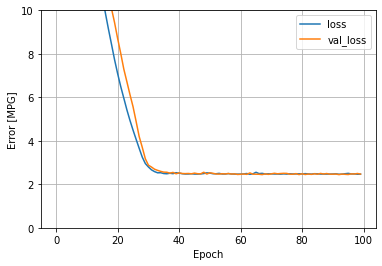

In [67]:
# Com a função para criar gráficos do erro por época criada anteriormente
# será avaliado neste modelo também

plot_loss(history)

In [68]:
# Os resultados serão coletados no conjunto teste
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regressão DNN

Nesta seção será implementada um modelo DNN. Diferentemente dos modelos anteriores, este conterá camadas 'ocultas' (hidden), que não estão ligadas diretamente à entrada ou saída, que realizam operações não lineares. Também será avaliado em um único dado de entrada e múltiplos

In [69]:
# Ambos modelo de única entrada quanto de múltipla irão utilizar a mesma
# estrutura de modelo e de treinamento, desta forma é criada uma função para
# agilizar o processo
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

## Uma variável

In [70]:
# Como o anterior será avaliado como única variável o 'hosrepower'
# e utilizado o normalizador já criado
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [71]:
# O modelo tem muito mais parâmetros que os anteriores como é possível ver a seguir
dnn_horsepower_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [73]:
%%time
# Agora será treinado o modelo
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 6.25 s


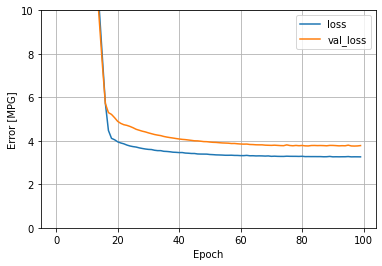

In [74]:
# Então será gerado o gráfico do treinamento e veremos que este se
# comporta melhor que o modelo linear-horsepower anterior
plot_loss(history)

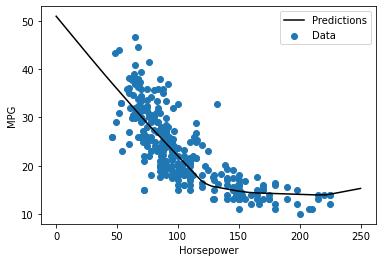

In [75]:
# Como é um modelo com apenas uma variável é facilmente possível criar
# um gráfico das predições e dos dados
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)
# Percebemos que a não linearidade com a camada 'relu' contribui para um melhor ajuste

In [76]:
# Os resultados também serão coletados
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## Múltiplas variáveis

In [77]:
# Agora será repetido o processo, modificando que serão utilizados todos os atributos
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [78]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 4.82 s


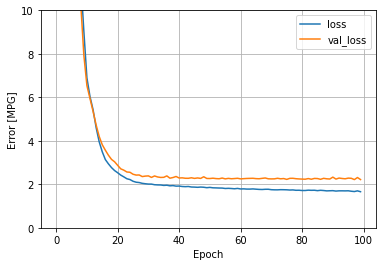

In [79]:
plot_loss(history)

In [80]:
# Os resultados serão coletados também
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Performance

In [81]:
# Agora que todos os modelos foram treinados e avaliados com os dados de teste
# veremos como eles foram
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.663748
linear_model,2.501489
dnn_horsepower_model,2.959413
dnn_model,1.796328


## Predições

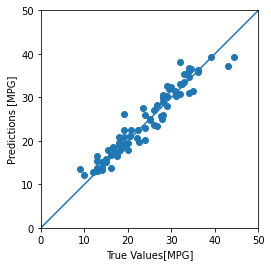

In [82]:
# Aqui serão avaliados os erros nos dados de teste a partir das previsões
# É utilizado um gráfico com o eixo x os valores verdadeiros e no eixo y os preditos

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values[MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

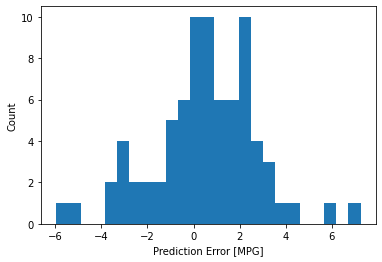

In [83]:
# Agora podemos olhar a distribuição dos erros também
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [84]:
# Este modelo pode ser salvo para ser utilizado em outro momento
dnn_model.save('dnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dnn_model\assets


In [85]:
# Caso seja recarregado o modelo, este irá gerar os mesmos resultados
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [87]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.663748
linear_model,2.501489
dnn_horsepower_model,2.959413
dnn_model,1.796328
reloaded,1.796328


Este trabalho é apenas o resultado do acompanhamento do tutorial Keras Regression disponível em tensorflow.org com alguns comentários acrescentados pelo autor. O copyright do tutorial está disponível a seguir

In [ ]:
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.